In [1]:
from submodule_04_Constants import (SEQ_LEN,EMBEDDING_DIM,BATCH_SIZE,NUM_LAYERS,NUM_HEADS,DROPOUT_RATE,EPOCHS,INPUT_DIM,NUM_MOVIES)
from submodule_04_Transformer import TransformerRecModel, train_model, evaluate_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [2]:
# Prepare the preprocessed data embeddings
movie_embeddings = pd.read_pickle("Dataset_Processed/Movie_Embeddings.pkl")

# Extract features for training
features = np.array(list(movie_embeddings['Description_Embedding']))    # Description embeddings
keywords = np.array(list(movie_embeddings['Keyword_Embedding']))        # Keyword embeddings
genres = movie_embeddings.loc[:, "Action":"Western"].values             # Genre embeddings
countries = movie_embeddings.loc[:, "Afghanistan":"Zimbabwe"].values    # Country embeddings
other_features = movie_embeddings[["Adult","Normalized_Release_Year","Normalized_Rating","Normalized_Popularity"]].values

# Training Features
X = np.hstack((features, keywords, genres, countries, other_features)) 
# Training Labels
y = movie_embeddings['ID'].values 

print(f"Features shape (X): {X.shape}") 
print(f"Labels shape   (y): {y.shape}") 

Features shape (X): (14010, 1707)
Labels shape   (y): (14010,)


In [3]:
# Create a function to reshape features into sequences
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    
    # Loop through the data and create sequences
    for i in range(len(X)):
        random_indices = random.sample(range(len(X)), seq_len-1)
        sequence = [X[j] for j in random_indices] # Add random movies as the first elements of the sequence

        sequence.append(X[i]) # Add the current movie as the last element of the sequence
        sequences.append(sequence)
        labels.append(y[i])
    
    return np.array(sequences), np.array(labels)

# Generate sequences from the original features and labels
X_sequences, y_sequences = create_sequences(X, y, SEQ_LEN)

# Check shapes
print("X_sequences shape:", X_sequences.shape)  # Should be (num_samples, SEQ_LEN, INPUT_DIM)
print("y_sequences shape:", y_sequences.shape)  # Should be (num_samples,)

X_sequences shape: (14010, 20, 1707)
y_sequences shape: (14010,)


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Combine Test and Train X tensors so that models can be trained on the entire dataset
X_train_tensor = torch.cat((X_train_tensor, X_test_tensor), 0)
y_train_tensor = torch.cat((y_train_tensor, y_test_tensor), 0)

# Dataset and Dataloader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

# Check final shapes
print("Final Training Data Shape:", X_train_tensor.shape)  # Should be (num_samples, SEQ_LEN, INPUT_DIM)
print("Final Training Labels Shape:", y_train_tensor.shape)  # Should be (num_samples,)

Final Training Data Shape: torch.Size([14010, 20, 1707])
Final Training Labels Shape: torch.Size([14010])


In [5]:
print(f"SEQ_LEN: {SEQ_LEN}, EMBEDDING_DIM: {EMBEDDING_DIM}, BATCH_SIZE: {BATCH_SIZE}, NUM_LAYERS: {NUM_LAYERS}, NUM_HEADS: {NUM_HEADS}, DROPOUT_RATE: {DROPOUT_RATE}, EPOCHS: {EPOCHS}, INPUT_DIM: {INPUT_DIM}, NUM_MOVIES: {NUM_MOVIES}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

SEQ_LEN: 20, EMBEDDING_DIM: 64, BATCH_SIZE: 32, NUM_LAYERS: 2, NUM_HEADS: 4, DROPOUT_RATE: 0.2, EPOCHS: 30, INPUT_DIM: 1707, NUM_MOVIES: 14010
Device: cuda


In [6]:
# Initialize Model, Optimizer, and Loss Function
model = TransformerRecModel(num_movies=NUM_MOVIES, input_dim=INPUT_DIM, sequence_len=SEQ_LEN, embedding_dim=EMBEDDING_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS, dropout_rate=DROPOUT_RATE)
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Lists to store loss values for plotting
train_losses = []
average_losses = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Training loop
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, optimizer, criterion, DEVICE)
    scheduler.step()
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}")

    avg_loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, criterion, DEVICE)
    average_losses.append(avg_loss)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_values.append(f1)

    # Evaluate on validation set
    if (epoch + 1) % 5 == 0:  
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'NN_Models/TransformerRecModel_{}_{}.pth'.format(EPOCHS, EMBEDDING_DIM))
print("Model saved successfully.")

C:\Users\nikra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/30, Loss: 9.6056
Epoch 2/30, Loss: 9.5694
Epoch 3/30, Loss: 9.5625
Epoch 4/30, Loss: 9.5562
Epoch 5/30, Loss: 9.5396
Validation Loss: 9.5176, Accuracy: 0.0007, Precision: 0.0000, Recall: 0.0007, F1 Score: 0.0000
Epoch 6/30, Loss: 9.5117
Epoch 7/30, Loss: 9.4835
Epoch 8/30, Loss: 9.4665
Epoch 9/30, Loss: 9.4567
Epoch 10/30, Loss: 9.4518
Validation Loss: 9.4501, Accuracy: 0.0021, Precision: 0.0009, Recall: 0.0021, F1 Score: 0.0010
Epoch 11/30, Loss: 9.4504
Epoch 12/30, Loss: 9.4510
Epoch 13/30, Loss: 9.4521
Epoch 14/30, Loss: 9.4523
Epoch 15/30, Loss: 9.4507
Validation Loss: 9.4339, Accuracy: 0.0064, Precision: 0.0034, Recall: 0.0064, F1 Score: 0.0037
Epoch 16/30, Loss: 9.4476
Epoch 17/30, Loss: 9.4440
Epoch 18/30, Loss: 9.4408
Epoch 19/30, Loss: 9.4387
Epoch 20/30, Loss: 9.4388
Validation Loss: 9.4139, Accuracy: 0.0621, Precision: 0.0502, Recall: 0.0621, F1 Score: 0.0521
Epoch 21/30, Loss: 9.4405
Epoch 22/30, Loss: 9.4428
Epoch 23/30, Loss: 9.4440
Epoch 24/30, Loss: 9.4429
Epoch

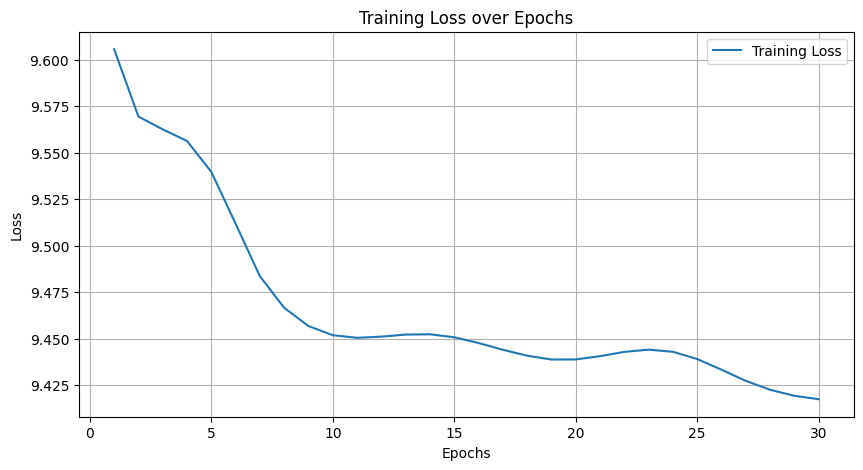

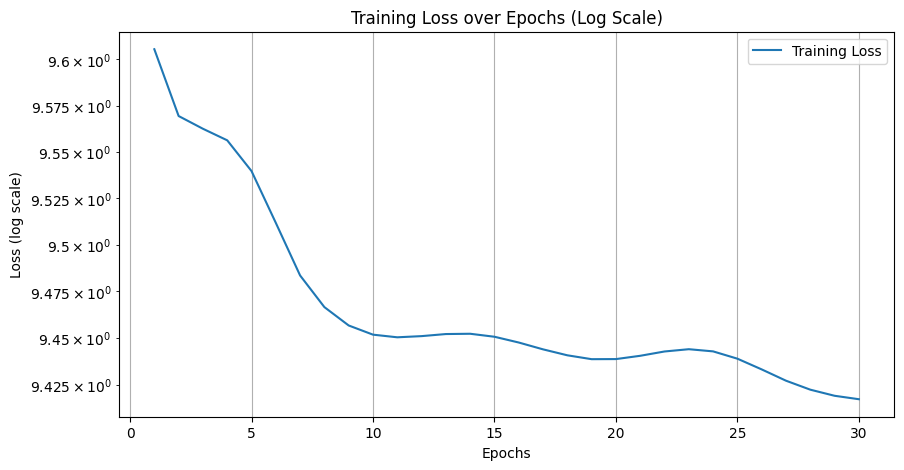

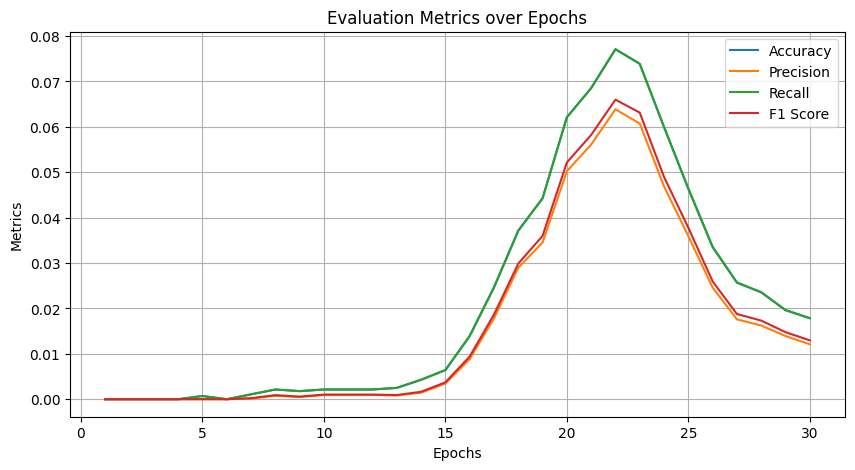

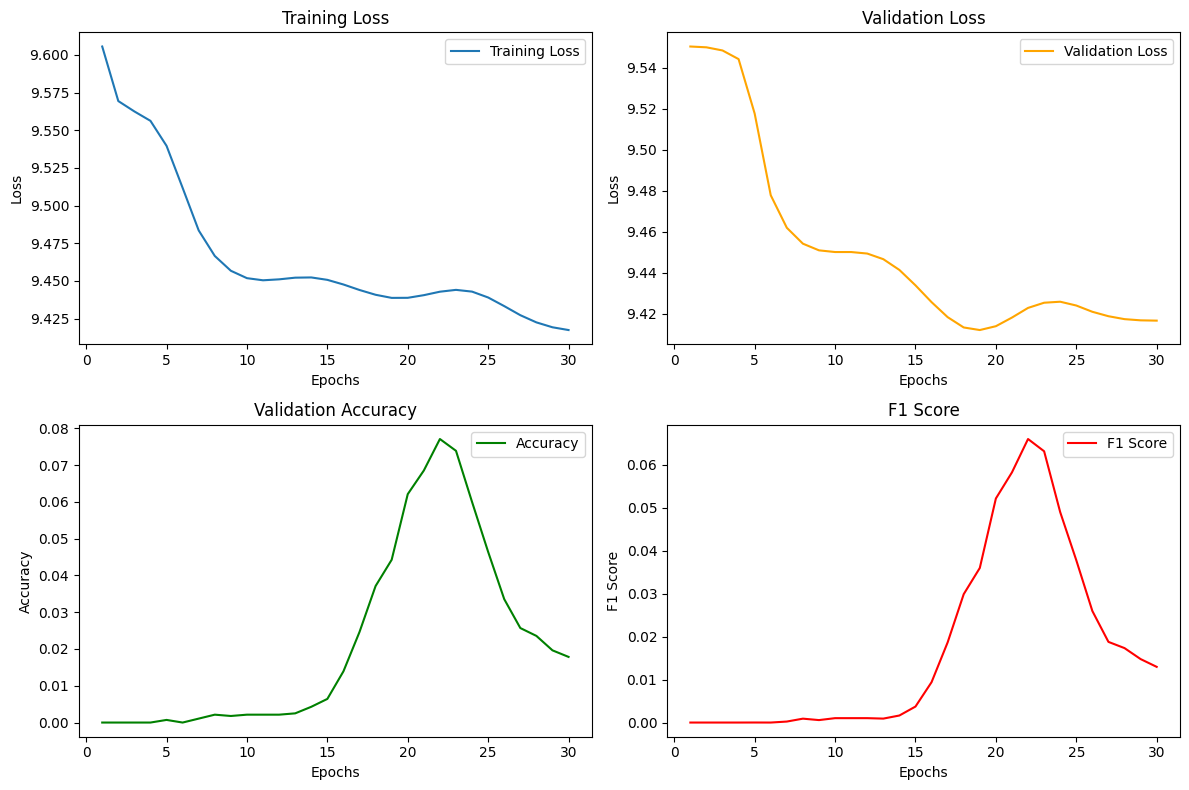

In [7]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('NN_Models/Training_Loss_{}_{}.png'.format(EPOCHS,EMBEDDING_DIM))
plt.show()

# Plotting the training loss with a log scale
plt.figure(figsize=(10, 5))
plt.semilogy(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss over Epochs (Log Scale)')
plt.legend()
plt.grid(True)
plt.savefig('NN_Models/Training_Loss_Log_{}_{}.png'.format(EPOCHS,EMBEDDING_DIM))
plt.show()

# Plotting the evaluation metrics
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), accuracy_values, label='Accuracy')
plt.plot(range(1, EPOCHS + 1), precision_values, label='Precision')
plt.plot(range(1, EPOCHS + 1), recall_values, label='Recall')
plt.plot(range(1, EPOCHS + 1), f1_values, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('NN_Models/Evaluation_Metrics_{}_{}.png'.format(EPOCHS,EMBEDDING_DIM))
plt.show()

# Plotting Loss and Metrics
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1) # Plot Training Loss
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2) # Plot Validation Loss
plt.plot(range(1, len(average_losses) + 1), average_losses, label='Validation Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3) # Plot Accuracy
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label='Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4) # Plot F1 Score
plt.plot(range(1, len(f1_values) + 1), f1_values, label='F1 Score', color='red')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.savefig('NN_Models/Evaluation_{}_{}.png'.format(EPOCHS,EMBEDDING_DIM))
plt.show()